# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

In [1]:
# Импортируем используемые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymystem3 import Mystem
from collections import Counter
import warnings
m = Mystem() 

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
# Считывание файла data.csv в датафрейм df и вывод информации о его структуре
df=pd.read_csv('/datasets/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [3]:
# Вывод первых 5 строк датафрейма
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


**Вывод**

Датасет состоит из 12 столбцов на 21525 строк. Два столбца имеют тип float64, по 5 int64 и object. Два столбца имеют пропуски в количестве 2174.

## Шаг 2. Предобработка данных

### Обработка пропусков

Выведем столбцы с пропущенными значениями в процентном соотношении к общему обьему

In [4]:
all_data = df.reset_index(drop=True)
print(f'all_data size is : {all_data.shape}')
all_data_na = (all_data.isna().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data

all_data size is : (21525, 12)


,Missing Ratio
total_income,10.099884
days_employed,10.099884


Пропущены значения по доходу и трудовой стаж
Выведем строки с пропущенными значениями

In [5]:
df[df['total_income'].isna()].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


Возможные причины пропуска: технологический сбои или отсутствие данных по клиентам
Сравним количество пропусков

In [6]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Выведем список по типу занятости

In [7]:
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

In [8]:
df[df['income_type']=='безработный']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
3133,1,337524.466835,31,среднее,1,женат / замужем,0,M,безработный,1,59956.991984,покупка жилья для сдачи
14798,0,395302.838654,45,Высшее,0,гражданский брак,1,F,безработный,0,202722.511368,ремонт жилью


Просмотр используемых значений по столбцам

In [9]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Заменим выбросы по children на возможные значения
Возможно допущена опечатка

In [10]:
df.loc[df['children'] == 20, 'children'] = 2
df.loc[df['children'] == -1, 'children'] = 1

Замена пропусков на медианные и средние значения
Проверим количество пропусков

In [11]:
df['total_income'].isnull().sum()

2174

In [12]:
# Использован перебор по уникальным значениям, чтобы предотвратить большое количество дубликатов при замене на среднее
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for i in df['income_type'].unique():
        for j in df['education_id'].unique():
            for n in df['family_status_id'].unique():
                for p in df['children'].unique():
                    try:
                        df.loc[(df['children']==p) & (df['family_status_id']==n) & (df['income_type']==i) & (df['education_id']==j) ,'total_income']=\
                        df.loc[(df['children']==p) & (df['family_status_id']==n) & (df['income_type']==i) & (df['education_id']==j) ,'total_income'].\
                        fillna(df.loc[(df['children']==p) & (df['family_status_id']==n) & (df['income_type']==i) & (df['education_id']==j) ,'total_income'].median())
                    except:
                        pass
# Заменяем на медиану, чтобы уменьшить смещение средних значений
df['total_income'].fillna(df['total_income'].median(), inplace=True)
df['total_income'].value_counts()      

135339.832421    284
112586.162231    162
138620.816715    125
138048.623570     97
161806.370168     90
                ... 
158637.693529      1
163856.100529      1
50468.619944       1
240127.623122      1
150014.128510      1
Name: total_income, Length: 19416, dtype: int64

Созданные ниже дубликаты можно полностью нивелировать, подключив расчет среднего
значения по возрасту, но тогда пересчет и заполнение займет значительное время

In [13]:
df['total_income'].isnull().sum()

0

Проверка по days_employed

In [14]:
print(df['days_employed'].min(),df['days_employed'].max())
df[df['days_employed'].isna()]['children'].count()

-18388.949900568383 401755.40047533


2174

Возьмем за основу, что стаж не может быть больше, чем  'возраст-16' и заменим пропуски по возрасту
при отсутсвии возраста на среднее значение

In [15]:
df.loc[df['dob_years']==0,'days_employed'].fillna(df['days_employed'].mean(), inplace=True)
df['days_employed'].fillna(((df['dob_years']-16)*365).mean(), inplace=True)

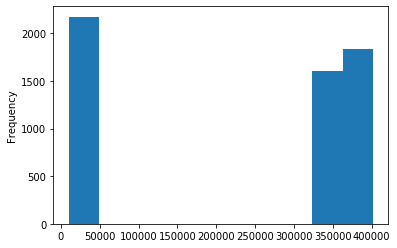

In [16]:
df[df['days_employed']>0]['days_employed'].plot(kind="hist")
# Значения не входят в допустимые нормы трудового стажа 0<X<20000, где 0-отсутствие, 20к-стаж более 50 лет

Но если самый верхний диапозон значений представить в часах, мы получим корректные значения в рамках возможного диапазона лет

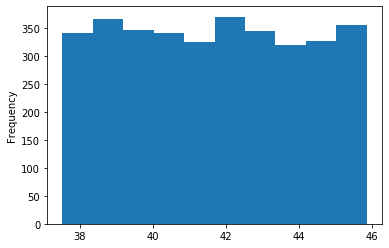

In [17]:
(df[df['days_employed']>100000]['days_employed']/365/24).plot(kind="hist")

Как видим средний диапазон это дубликаты появившиесие вследствие наличия пропусков сразу по двум столбцам, поэтому
оставим их без изменений

Уникальные значения: [9962.08362369]


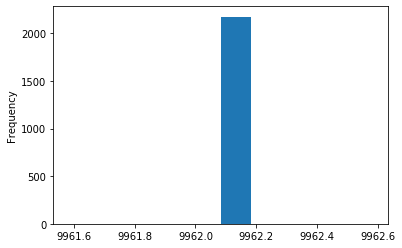

In [18]:
df.loc[(df['days_employed']>0) & (df['days_employed']<100000)]['days_employed'].plot(kind="hist")
print("Уникальные значения:",df.loc[(df['days_employed']>0) & (df['days_employed']<100000)]['days_employed'].unique())

Исправим выбросы по days_employed

In [19]:
df['days_employed']=df['days_employed'].abs()
df.loc[df['days_employed']>50000,'days_employed']=df['days_employed']/24
print("Минимальный трудовой стаж(лет):",(df['days_employed'].min()/365).astype('int'))
print("Максимальный трудовой стаж(лет):",(df['days_employed'].max()/365).astype('int'))

Минимальный трудовой стаж(лет): 0
Максимальный трудовой стаж(лет): 50


Диаграмма распределения стажа в годах

[]

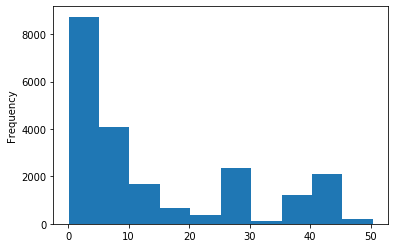

In [20]:
(df['days_employed']/365).plot(kind="hist").plot(kind="hist")

Диаграмма распределения стажа до 5 лет

[]

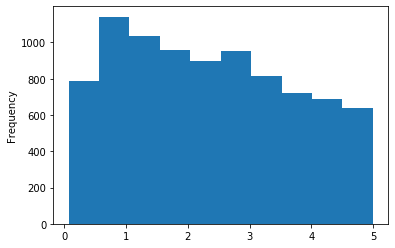

In [21]:
(df[df['days_employed']<5*365]['days_employed']/365).plot(kind="hist").plot(kind="hist")

dob_years

In [22]:
", ".join(str(x) for x in sorted(df['dob_years'].unique()))

'0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75'

Заменим выбросы по dob_years=0 на возможные значения

In [23]:
", ".join(str(x) for x in sorted(df.loc[df['dob_years']==0,'days_employed'].unique()))
# Из многочисленнных выбрпосов по days_employed все попадают в допустимые значения для расчета возраста клиента
# и не являются исключительно дубликатами

'108.96704186614716, 162.9369524996826, 176.40448651346043, 202.60050760136468, 223.70954465671744, 229.5609334617141, 260.9927218209444, 334.8372846817857, 368.83819395863634, 401.4612616684065, 457.249346910462, 477.3243601995604, 681.9073586027741, 731.3967940070198, 742.201082195978, 794.876230496055, 866.2739905539978, 899.6856813830016, 906.5194461676692, 908.172636778831, 913.1532094617396, 934.6548535237537, 947.2752580327997, 986.789229581294, 1015.3954505009738, 1018.5252830182484, 1036.6440005843424, 1095.3866218238682, 1146.6895862897618, 1158.0295614096926, 1245.6582439567308, 1268.4877281976171, 1371.2072224675173, 1409.5001778464111, 1478.0924671735675, 1524.8692995442475, 1551.3804023242892, 1570.4204596222814, 1572.0521360877215, 1605.5061613215619, 1611.3606094753068, 1641.3412835634408, 1653.9728450158661, 1720.866869827683, 1753.4482654685287, 1759.0380334153665, 1872.663186426345, 1875.9720125305307, 1935.4022510749105, 2156.3902731736016, 2161.5915186437733, 2356.

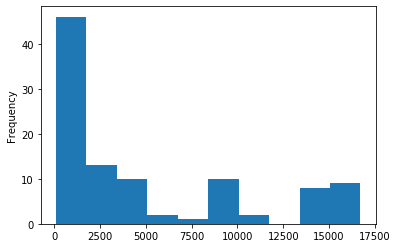

In [24]:
df.loc[df['dob_years']==0,'days_employed'].plot(kind="hist")

In [25]:
df.loc[df['dob_years']==0,'dob_years']=(df['days_employed']/365)+16

Проверим значения gender

In [26]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

XNA - возможно имелось введу - "Цисгендерность not available", т.е заменяем на наиболее частый

In [27]:
df.loc[df['gender'] == 'XNA', 'gender'] = 'F'
df['gender'].value_counts()

F    14237
M     7288
Name: gender, dtype: int64

**Вывод**

Столбцы days_employed и income_type имеют пропуски в одних и тех же строках - это может говорить о том, что клиент не имеет дохода или не трудоустроен, но отсутствие корелляции не позволяет сделать такие выводы. Для обработки пропусков лучшим вариантом будет дозапрос пропущенных данных, но при его отсутствии был выбран вариант восстановления данных, т.к удаление 10% датефрейма является довольно существенным.  
Били исправлены выбросы по столбцам без удаления строк, а также минимизировано использование средних значений путем пересчета значений из соседних столбцов.

### Замена типа данных

Изучим используемые типы

In [28]:
df.dtypes

children              int64
days_employed       float64
dob_years           float64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object

Избавимся от значения с плавающей запятой для целых значений
Выбран метод astype() для четкого указания типа значений

In [29]:
df['days_employed']=df['days_employed'].astype('uint16')
df['dob_years']=df['dob_years'].astype('uint8')
df['total_income']=df['total_income'].astype('int')

Проведем оптимизацию типов столбцов по типу данных и выведем результат

In [30]:
# Метод позволяет определить наименьший тип данных, для ускорения вычислений датафрейма и уменьшения занимаемой памяти
for col in df.columns:
    if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
        if df[col].min() >= 0:
            df[col] = pd.to_numeric(df[col], downcast='unsigned')
        else:
            df[col] = pd.to_numeric(df[col], downcast='integer')

    elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
        df[col] = pd.to_numeric(df[col], downcast='float')

    elif df[col].dtypes.kind == 'O':
        num_unique_values = len(df[col].unique())
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')


df.dtypes

children               uint8
days_employed         uint16
dob_years              uint8
education           category
education_id           uint8
family_status       category
family_status_id       uint8
gender              category
income_type         category
debt                   uint8
total_income          uint32
purpose             category
dtype: object

**Вывод**

Привели типы столбцов количество дней и доход к целочисленным значениям и оптимизировали по типам данных.

### Обработка дубликатов

Проверим и исправим столбцы при наличии повторяющихся значений

In [31]:
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Используем метод понижающего регистра

In [32]:
df['education']=df['education'].str.lower().astype('category')

In [33]:
df['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [34]:
df['family_status']=df['family_status'].str.lower().astype('category')

In [35]:
df['gender'].value_counts()

F    14237
M     7288
Name: gender, dtype: int64

In [36]:
df['income_type'].unique()

[сотрудник, пенсионер, компаньон, госслужащий, безработный, предприниматель, студент, в декрете]
Categories (8, object): [сотрудник, пенсионер, компаньон, госслужащий, безработный, предприниматель, студент, в декрете]

Проверим количество дубликатов строк

In [37]:
df.duplicated().sum()

71

In [38]:
df[df.duplicated(keep=False)].sort_values(by='dob_years').head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
20297,1,9962,23,среднее,1,гражданский брак,1,F,сотрудник,0,138442,сыграть свадьбу
8853,1,9962,23,среднее,1,гражданский брак,1,F,сотрудник,0,138442,сыграть свадьбу
15892,0,9962,23,среднее,1,не женат / не замужем,4,F,сотрудник,0,130990,сделка с подержанным автомобилем
19321,0,9962,23,среднее,1,не женат / не замужем,4,F,сотрудник,0,130990,сделка с подержанным автомобилем
3452,0,9962,29,высшее,0,женат / замужем,0,M,сотрудник,0,171859,покупка жилой недвижимости
18328,0,9962,29,высшее,0,женат / замужем,0,M,сотрудник,0,171859,покупка жилой недвижимости
4216,0,9962,30,среднее,1,женат / замужем,0,M,сотрудник,0,135339,строительство жилой недвижимости
6312,0,9962,30,среднее,1,женат / замужем,0,M,сотрудник,0,135339,строительство жилой недвижимости
18349,1,9962,30,высшее,0,женат / замужем,0,F,госслужащий,0,152420,покупка жилья для семьи
8629,1,9962,30,высшее,0,женат / замужем,0,F,сотрудник,0,165009,покупка коммерческой недвижимости


Исправим имеющиеся дубликаты путем удаления, т.к не содержат полезной информации

In [39]:
df=df.drop_duplicates().reset_index(drop= True)

**Вывод**

Были обнаружены дубликаты при использовании различных типов регистра, а также повторяющиеся записи строк. Путем использованием метода str.lower внесли исправления в повторяющиеся записи и удалили дубликаты drop_duplicates().
Возможная причина появления дубликатов - технологическая ошибка.

### Лемматизация

Выведем список целей кредита

In [40]:
p=df['purpose'].value_counts()
print(p)

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Лемматизируем цели кредита по уникадьным значениям

In [41]:
lemmas = m.lemmatize(' '.join(df['purpose'].unique()))
print(Counter(lemmas))

Counter({' ': 96, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})


Выделим основные цели из проведенной лемматизации

In [42]:
purpose={'недвижимость/жилье':0,'автомобиль':0,'образование':0,'свадьба':0}

Проверим точность выделенных целей кредита

In [43]:
# Функция подсвечивает леммы для проверки и возвращает категорию в числе
str_lst=[]
def purpose_type(index):
    for item in purpose.keys():
        for word in item.split("/"):
            wr=' '.join(list(filter(lambda x: word in m.lemmatize(x), index.split())))
            if len(wr)>0:
                ret=list(purpose.keys()).index(item)
                purpose[item]+=value
                str_val=(str(index[:index.find(wr)]+"\033[31m"+index[index.find(wr):index.find(wr)+len(wr)]+"\033[0m"+\
                            index[index.find(wr)+len(wr):]))
                str_val=("{0} --- {1}").format(item,str_val)
    return str(ret)+"*"+str_val

for index, value in p.items():
    str_lst.append(purpose_type(index).split("*")[1])
p.index=str_lst
p

свадьба --- свадьба                                              791
свадьба --- на проведение свадьбы                                768
свадьба --- сыграть свадьбу                                      765
недвижимость/жилье --- операции с недвижимостью                  675
недвижимость/жилье --- покупка коммерческой недвижимости         661
недвижимость/жилье --- операции с жильем                         652
недвижимость/жилье --- покупка жилья для сдачи                   651
недвижимость/жилье --- операции с коммерческой недвижимостью     650
недвижимость/жилье --- жилье                                     646
недвижимость/жилье --- покупка жилья                             646
недвижимость/жилье --- покупка жилья для семьи                   638
недвижимость/жилье --- строительство собственной недвижимости    635
недвижимость/жилье --- недвижимость                              633
недвижимость/жилье --- операции со своей недвижимостью           627
недвижимость/жилье --- строительст

Подсчитаем частоту использования целей и визуализируем соотношение

{'недвижимость/жилье': 10811,
 'автомобиль': 4306,
 'образование': 4013,
 'свадьба': 2324}

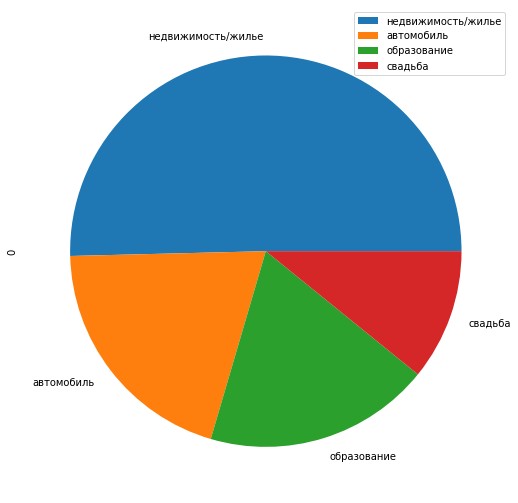

In [44]:
pd.DataFrame.from_dict(purpose, orient='index').plot(kind="pie", subplots=True, figsize=(9, 9))
purpose

**Вывод**

Провели лемматизацию всех используемых целей кредита по уникальным значениям и выделили основные направления. В основные направления входят: недвижимость/жилье, автомобиль, образование, свадьба. 

### Категоризация данных

Категоризация по children: 0 - нет детей, 1 - есть дети

In [45]:
df.insert(1, 'children_id',0)
df['children_id'] = (df['children']>0).astype('uint8')

Категоризация по gender, 0/1 - пол

In [46]:
df.insert(9, 'gender_id',0)
df['gender_id']=df['gender'].map({"F":0,"M":1}).astype('uint8')

Категоризация по income_type, нумерация уникальных значений

In [47]:
df.insert(11, 'income_type_id',0)
df['income_type'].value_counts()

сотрудник          11084
компаньон           5078
пенсионер           3829
госслужащий         1457
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

In [48]:
un_val=dict(enumerate(df['income_type'].unique()))
df['income_type_id'] = df['income_type'].map(dict(zip(un_val.values(),un_val.keys()))).astype('uint8')

Категоризация по total_income, нумерация 0-5 по диапазонам дохода
Необходима для дальнейшей работы с корреляцией

In [49]:
df.insert(14, 'total_income_id',0)
def income(income):
    if income <= 50000:
        return 0
    elif income <= 100000:
        return 1
    elif income <= 150000:
        return 2
    elif income <= 200000:
        return 3    
    elif income <= 250000:
        return 4   
    else:
        return 5
df['total_income_id'] = df['total_income'].apply(income)

Категоризация по purpose, нумерация 0-3 по основным целям

In [50]:
# Использована ранее оописанная функция определения категории
df.insert(16, 'purpose_id',0)
df['purpose_id']=df['purpose'].map(purpose_type).str.split("*", n=1, expand=True)
df['purpose_id']=df['purpose_id'].astype('uint8')

In [51]:
df.head(10)

,children,children_id,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,gender_id,income_type,income_type_id,debt,total_income,total_income_id,purpose,purpose_id
0,1,1,8437,42,высшее,0,женат / замужем,0,F,0,сотрудник,0,0,253875,5,покупка жилья,0
1,1,1,4024,36,среднее,1,женат / замужем,0,F,0,сотрудник,0,0,112080,2,приобретение автомобиля,1
2,0,0,5623,33,среднее,1,женат / замужем,0,M,1,сотрудник,0,0,145885,2,покупка жилья,0
3,3,1,4124,32,среднее,1,женат / замужем,0,M,1,сотрудник,0,0,267628,5,дополнительное образование,2
4,0,0,14177,53,среднее,1,гражданский брак,1,F,0,пенсионер,1,0,158616,3,сыграть свадьбу,3
5,0,0,926,27,высшее,0,гражданский брак,1,M,1,компаньон,2,0,255763,5,покупка жилья,0
6,0,0,2879,43,высшее,0,женат / замужем,0,F,0,компаньон,2,0,240525,4,операции с жильем,0
7,0,0,152,50,среднее,1,женат / замужем,0,M,1,сотрудник,0,0,135823,2,образование,2
8,2,1,6929,35,высшее,0,гражданский брак,1,F,0,сотрудник,0,0,95856,1,на проведение свадьбы,3
9,0,0,2188,41,среднее,1,женат / замужем,0,M,1,сотрудник,0,0,144425,2,покупка жилья для семьи,0


**Вывод**

Провели категорирование по количеству детей, полу, типу занятости, цели получения кредита и доходу. Добавлены соответствующие столбцы.

## Шаг 3. Ответьте на вопросы

Мзучим children по dept

In [52]:
display(df.groupby('children_id').agg({'debt': ['count', 'sum']}))
df.groupby('children').agg({'debt': ['count', 'sum']})

debt        
             count     sum
children_id               
0            14091  1063.0
1             7363   678.0

debt        
          count     sum
children               
0         14091  1063.0
1          4855   445.0
2          2128   202.0
3           330    27.0
4            41     4.0
5             9     0.0

Корреляция по количеству детей

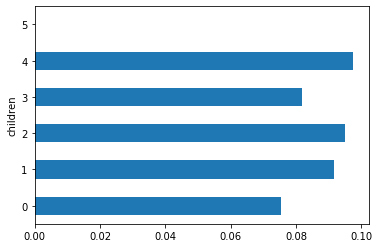

In [53]:
df.groupby(['children']).debt.mean().plot(kind="barh")

Рассчитаем вероятность просрочки

In [54]:
df.groupby(['children']).debt.mean()

children
0    0.075438
1    0.091658
2    0.094925
3    0.081818
4    0.097561
5    0.000000
Name: debt, dtype: float64

**Вывод**

Наименьшая вероятность просрочки у клиентов без детей, наибольшая у имеющих 4 ребенка.

Мзучим family_status по dept

In [55]:
df.loc[df['debt']==1,'family_status'].value_counts()

женат / замужем          931
гражданский брак         388
не женат / не замужем    274
в разводе                 85
вдовец / вдова            63
Name: family_status, dtype: int64

Корреляция по семейному положению

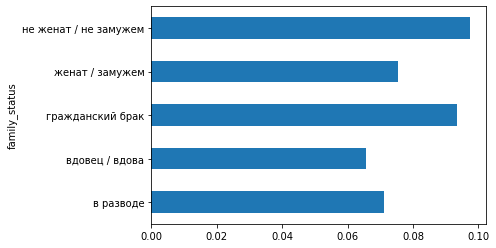

In [56]:
df.groupby(['family_status']).debt.mean().plot(kind="barh")

Рассчитаем вероятность просрочки

In [57]:
df.groupby(['family_status']).debt.mean()

family_status
в разводе                0.071130
вдовец / вдова           0.065693
гражданский брак         0.093471
женат / замужем          0.075452
не женат / не замужем    0.097509
Name: debt, dtype: float64

**Вывод**

Наименьшая вероятность просрочки у вдовцов, наибольшая у неженатых/незамужних и в гражданском браке.

Изучим корреляцию по доходу. Рассчитаем вероятность просрочки

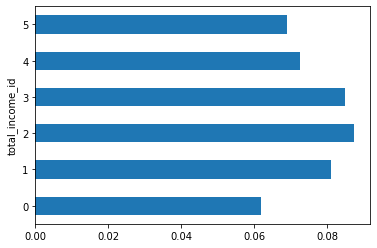

In [58]:
df.groupby(['total_income_id']).debt.mean().plot(kind="barh")

In [59]:
df.groupby(['total_income_id']).debt.mean()

total_income_id
0    0.061828
1    0.081035
2    0.087500
3    0.084882
4    0.072574
5    0.068966
Name: debt, dtype: float64

**Вывод**

Наименьшая вероятность просрочки у доходов до 50к, наибольшая 100-150к.

Мзучим purpose по dept

In [60]:
print(dict(enumerate(purpose.keys())))
df.loc[df['debt']==1,'purpose_id'].value_counts()

{0: 'недвижимость/жилье', 1: 'автомобиль', 2: 'образование', 3: 'свадьба'}


0    782
1    403
2    370
3    186
Name: purpose_id, dtype: int64

Корреляция по цели кредита

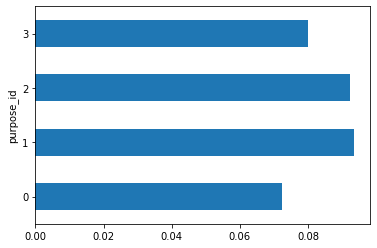

In [61]:
df.groupby(['purpose_id']).debt.mean().plot(kind="barh")

Рассчитаем вероятность просрочки

In [62]:
df.groupby(['purpose_id']).debt.mean()

purpose_id
0    0.072334
1    0.093590
2    0.092200
3    0.080034
Name: debt, dtype: float64

**Вывод**

Наименьшая вероятность у недвижемости, наибольшая у авто и образования.

## Шаг 4. Общий вывод

Подготовлен датафрейм с информацией о заемщиках, проведена предобработка данных.
Составлены критерии влияющие на возврат кредита в срок.

Идеальный клиент:
- не имеет детей;
- вдовец/вдова или разведены;
- имеет небольшой доход;
- берет деньги на покупку недвижимости

Клиент с высоким риска не возврата:
- имеет много детей;
- не состоит в браке;
- имеет доход 100-150к;
- берет деньги на авто или образование;